## PreProcessing Step
### the following issues need to be handled
1. some images are inverted (white is used for font and black for background unlike the majority)
2. light differs (you need to binarize and enhance the image quality)



In [9]:
from preprocessing import *
from feature_extraction import *
import torch
from torch import nn, optim
from nn_utils import nn_train, nn_predict, nn_accuracy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
classes = ['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']

In [10]:
X, Y = load_data()
print(X.shape)
print(Y.shape)
print(X[0])
print(Y[0])

(1684,)
(1684,)
ACdata_base/1/0001.jpg
1


In [119]:
split_data(X, Y)

In [34]:
def featureNormalize(X):
    mu = np.mean(X)
    sigma = np.std(X)
    normalized_X = (X-mu)/sigma
    
    return normalized_X

In [11]:
class Preprocessing(object):
    def __call__(self,img):
#         print(img)
        binaryImage = binraization(np.asarray(img.convert('L')))
#         binaryImage = getAreaOfInterest(binaryImage)
#         print(binaryImage.shape)
        return binaryImage


class FeatureExtraction(object):
    def __call__(self,img):
        feature_dim = 360
        features = extract_EOH(img, feature_dim)
#         features = lpq(img)
        
        return features


In [13]:
from torchvision import datasets, transforms, models
import time


train_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])
valid_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])
test_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])

t1 = time.time()
train_data = np.array(datasets.ImageFolder('d/train', transform=train_transforms), dtype=object)
# print(train_data)
X_train, Y_train = np.stack(train_data[:, 0]), train_data[:, 1].astype(np.uint8)
valid_data = np.array(datasets.ImageFolder('d/valid', transform=valid_transforms), dtype=object)
X_valid, Y_valid = np.stack(valid_data[:, 0]), valid_data[:, 1].astype(np.uint8)
test_data = np.array(datasets.ImageFolder('d/test', transform=test_transforms), dtype=object)
X_test, Y_test = np.stack(test_data[:, 0]), test_data[:, 1].astype(np.uint8)
print(time.time() - t1)

5.4366302490234375


In [14]:
X_train = torch.from_numpy(X_train)
print(X_train.shape)
Y_train = torch.from_numpy(Y_train)
print(Y_train.shape)
X_valid = torch.from_numpy(X_valid)
print(X_valid.shape)
Y_valid = torch.from_numpy(Y_valid)
print(Y_valid.shape)
X_test = torch.from_numpy(X_test)
print(X_test.shape)
Y_test = torch.from_numpy(Y_test)
print(Y_test.shape)

torch.Size([1010, 360])
torch.Size([1010])
torch.Size([337, 360])
torch.Size([337])
torch.Size([337, 360])
torch.Size([337])


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.7600, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1092, 0.0158, 0.0000,  ..., 0.0029, 0.0000, 0.0057],
        [0.0695, 0.0021, 0.0042,  ..., 0.0000, 0.0063, 0.0042]],
       dtype=torch.float64)


Trial Number #1
training model .......


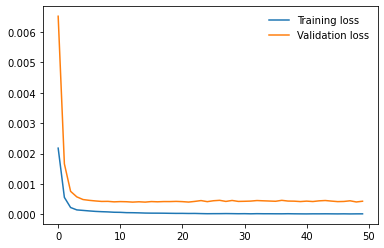

training accuracy = 100.0%
validation accuracy = 95.25222551928783%
test accuracy = 96.73590504451039%
-------------------------------------------------------------------------------------
Trial Number #2
training model .......


KeyboardInterrupt: 

In [16]:
# from nn_utils import *

validation_accuracy, test_accuracy = 0, 0
trialNum = 1

while validation_accuracy < 98.5 or test_accuracy < 98.5:
    print(f'Trial Number #{trialNum}')
    trialNum += 1
#     print('splitting data .....')
#     split_data(X, Y)

#     print('preprocessing and extracting features .....')
#     train_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])
#     valid_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])
#     test_transforms = transforms.Compose([Preprocessing(), FeatureExtraction()])

#     train_data = np.array(datasets.ImageFolder('data/train', transform=train_transforms), dtype=object)
#     X_train, Y_train = np.stack(train_data[:, 0]), train_data[:, 1].astype(np.uint8)
#     valid_data = np.array(datasets.ImageFolder('data/valid', transform=valid_transforms), dtype=object)
#     X_valid, Y_valid = np.stack(valid_data[:, 0]), valid_data[:, 1].astype(np.uint8)
#     test_data = np.array(datasets.ImageFolder('data/test', transform=test_transforms), dtype=object)
#     X_test, Y_test = np.stack(test_data[:, 0]), test_data[:, 1].astype(np.uint8)

#     X_train = torch.from_numpy(X_train)
#     Y_train = torch.from_numpy(Y_train)
#     X_valid = torch.from_numpy(X_valid)
#     Y_valid = torch.from_numpy(Y_valid)
#     X_test = torch.from_numpy(X_test)
#     Y_test = torch.from_numpy(Y_test)


    print('training model .......')
    model = nn.Sequential(nn.Linear(360, 1024),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(1024, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512, 9),
                        nn.LogSoftmax(dim=1))

    train_losses, validation_losses =\
        nn_train(model, X_train, Y_train, X_valid, Y_valid, epochs=5000, lr=0.001, validate_every=100, debug=False)

    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    train_predictions = nn_predict(model, X_train)
    validation_predictions = nn_predict(model, X_valid)
    test_predictions = nn_predict(model, X_test)

    validation_accuracy = nn_accuracy(validation_predictions, Y_valid) * 100
    test_accuracy = nn_accuracy(test_predictions, Y_test) * 100
    
    print(f'training accuracy = {nn_accuracy(train_predictions, Y_train) * 100}%')
    print(f'validation accuracy = {validation_accuracy}%')
    print(f'test accuracy = {test_accuracy}%')
    print('-------------------------------------------------------------------------------------')

In [157]:
torch.save(model.state_dict(), 'model.pth')
# model.load_state_dict(torch.load('model.pth'))

train_predictions = nn_predict(model, X_train)
validation_predictions = nn_predict(model, X_valid)
test_predictions = nn_predict(model, X_test)

print(f'training accuracy = {nn_accuracy(train_predictions, Y_train) * 100}%')
print(f'validation accuracy = {nn_accuracy(validation_predictions, Y_valid) * 100}%')
print(f'test accuracy = {nn_accuracy(test_predictions, Y_test) * 100}%')

training accuracy = 100.0%
validation accuracy = 98.51632047477746%
test accuracy = 98.21958456973294%


In [11]:
for i in range(9):
    print('[INFO]')
    print(f'training accuracy for class: #{i+1} = {nn_accuracy(train_predictions[Y_train == i], Y_train[Y_train == i]) * 100}%')
    print(f'valid accuracy for class: #{i+1} = {nn_accuracy(validation_predictions[Y_valid == i], Y_valid[Y_valid == i]) * 100}%')
    print(f'test accuracy for class: #{i+1} = {nn_accuracy(test_predictions[Y_test == i], Y_test[Y_test == i]) * 100}%')
    print()

[INFO]
training accuracy for class: #1 = 100.0%
valid accuracy for class: #1 = 97.43589743589743%
test accuracy for class: #1 = 100.0%

[INFO]
training accuracy for class: #2 = 100.0%
valid accuracy for class: #2 = 97.72727272727273%
test accuracy for class: #2 = 100.0%

[INFO]
training accuracy for class: #3 = 100.0%
valid accuracy for class: #3 = 97.05882352941177%
test accuracy for class: #3 = 97.14285714285714%

[INFO]
training accuracy for class: #4 = 99.1304347826087%
valid accuracy for class: #4 = 84.61538461538461%
test accuracy for class: #4 = 96.7741935483871%

[INFO]
training accuracy for class: #5 = 98.33333333333333%
valid accuracy for class: #5 = 95.1219512195122%
test accuracy for class: #5 = 91.17647058823529%

[INFO]
training accuracy for class: #6 = 100.0%
valid accuracy for class: #6 = 100.0%
test accuracy for class: #6 = 100.0%

[INFO]
training accuracy for class: #7 = 100.0%
valid accuracy for class: #7 = 100.0%
test accuracy for class: #7 = 100.0%

[INFO]
training

(135, 789)


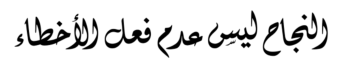

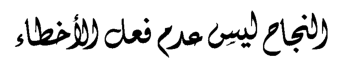

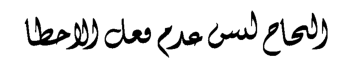

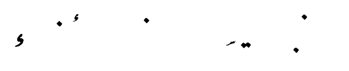

In [8]:
# import cv2
# import matplotlib.pyplot as plt
from preprocessing import *

img = cv2.imread(f'/home/islamahmed1092/Desktop/arabic-caligraphy-font-identification/Project Submission/test/1.png', cv2.IMREAD_GRAYSCALE)
# random_index = np.random.randint(0, 1683)

# Plot the image.
print(img.shape)
plt.imshow(img, 'gray')
plt.axis("off")
plt.show()

binaryImage = binraization(img)
plt.imshow(binaryImage, 'gray')
plt.axis("off")
plt.show()

textOnly, diacritics = diacriticsSegmentationClustering(binaryImage//255)
plt.imshow(textOnly, 'gray')
plt.axis("off")
plt.show()

plt.imshow(diacritics, 'gray')
plt.axis("off")
plt.show()

# print("The ground-truth value of this image is: ",
#       classes[Y[random_index]-1])

In [55]:
def getAreaOfInterest(originalImage):
    img = originalImage.copy()
#     show_images([img],["original"])

    edges = cv2.Canny(img, 30, 150)
    # show_images([edges], ['edges'])


    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.dilate(edges, kernel, iterations=1)//255
    # show_images([dilate], ['dilate'])

    threshold = 10


    hp = (dilate).sum(axis=1)
    vp = (dilate).sum(axis=0)

    h_occurances = np.where(hp>threshold)[0]
    v_occurances = np.where(vp>threshold)[0]

    rs, re = h_occurances[0], h_occurances[-1]
    cs, ce = v_occurances[0], v_occurances[-1]

    cropped = img[rs:re+1, cs:ce+1]
    
    return cropped
#     show_images([cropped], ['cropped'])

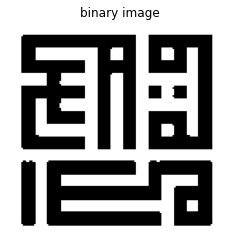

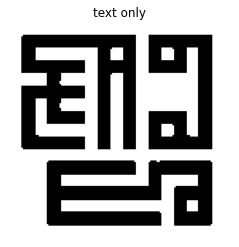

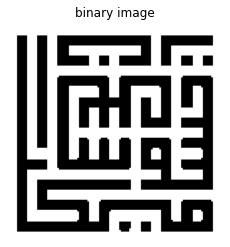

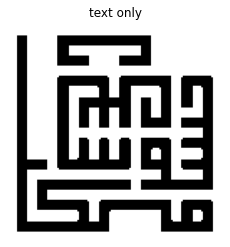

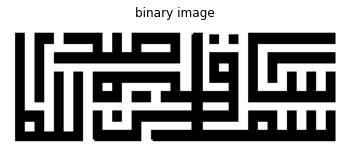

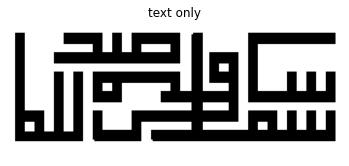

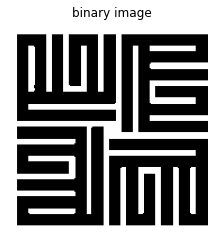

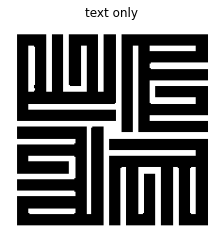

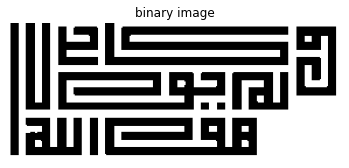

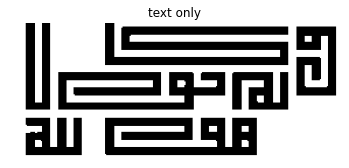

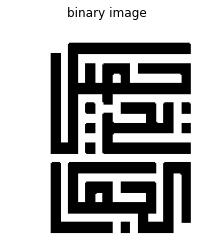

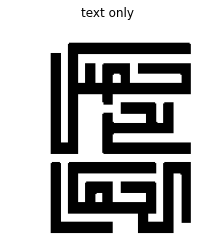

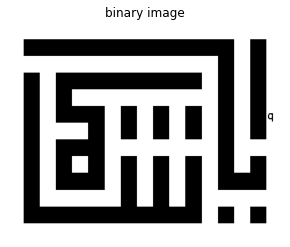

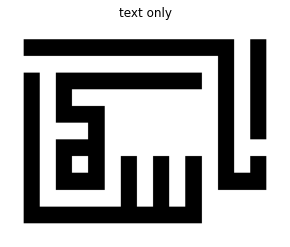

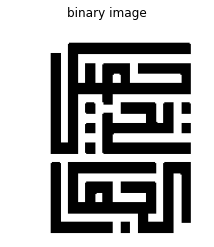

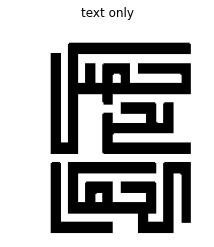

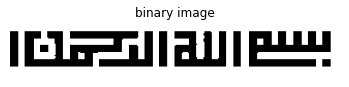

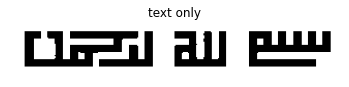

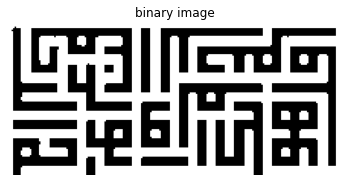

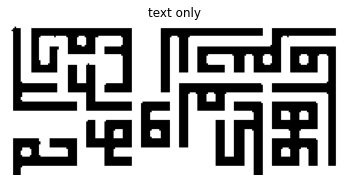

In [15]:
for random_index in range(1495, 1505):
    binaryImage = binraization(X[random_index])
    edges, skeleton, textOnly, diacritics = extractImagesSet(binaryImage//255)

    plt.imshow(binaryImage, 'gray')
    plt.title('binary image')
    plt.axis("off")
    plt.show()


    plt.imshow(textOnly, 'gray')
    plt.title('text only')
    plt.axis("off")
    plt.show()

#     horizontal = np.copy(1-edges)
#     vertical = np.copy(1-edges)

#     cols = horizontal.shape[1]
#     horizontal_size = cols // 20
#     horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
#     horizontal = cv2.morphologyEx(horizontal, cv2.MORPH_OPEN, horizontalStructure)

#     rows = vertical.shape[0]
#     verticalsize = rows // 20
#     verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
#     vertical = cv2.morphologyEx(vertical, cv2.MORPH_OPEN, verticalStructure)

#     show_images([horizontal], ['horizontal lines'])
#     show_images([vertical], ['vertical lines'])

#     HL = cv2.connectedComponents(horizontal)[0]-1
#     VL = cv2.connectedComponents(vertical)[0]-1

#     print(f'number of horizontal lines:{HL}')
#     print(f'number of vertical lines:{VL}')

In [181]:
VL = cv2.connectedComponents(vertical)[0]-1

# for i in range(0, numLabels):
#     if i == 0:
#         text = "examining component {}/{} (background)".format(
#             i + 1, numLabels)
#     else:
#         text = "examining component {}/{}".format( i + 1, numLabels)
    
#     print("[INFO] {}".format(text))
    
#     x = stats[i, cv2.CC_STAT_LEFT]
#     y = stats[i, cv2.CC_STAT_TOP]
#     w = stats[i, cv2.CC_STAT_WIDTH]
#     h = stats[i, cv2.CC_STAT_HEIGHT]
#     area = stats[i, cv2.CC_STAT_AREA]
#     (cX, cY) = centroids[i]

#     output = cv2.cvtColor(vertical*255, cv2.COLOR_GRAY2BGR)
#     cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
#     cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    
#     show_images([output], [f'component #{i}'])
    

ValueError: not enough values to unpack (expected 4, got 2)

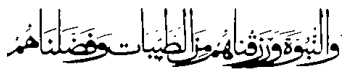

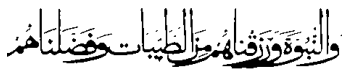

In [85]:

random_index = np.random.randint(0, 1683)
img = X[random_index].copy()
plt.figure()
plt.imshow(img, 'gray')
plt.axis("off")
plt.show()

binaryImage = binraization(img)
plt.figure()
plt.imshow(binaryImage, 'gray')
plt.axis("off")
plt.show()



In [90]:
feature_dim = 360
features = np.zeros((X.shape[0], feature_dim))
for i in range(X.shape[0]):
    X[i] = binraization(X[i])

#     edges, skeleton, textOnly, diacritics = extractImagesSet(X[i] // 255)
    features[i] = extract_EOH(X[i], feature_dim)

# features, labels = [], []

# for i in range(X.shape[0]):
#     X[i] = binraization(X[i])
# #     Xi_textOnly, _ = diacriticsSegmentationClustering(X[i]//255)
#     features.append(extract_hog_features(X[i]))
# #     features.append(extract_hog_features(Xi_textOnly*255))
# #     labels.append(Y[i])
# #     labels.append(Y[i])

# features = np.asarray(features)
# # labels = np.asarray(labels)
# print(features.shape)
# # print(labels.shape)

In [88]:
# print(X_train.shape, Y_train.shape)
# print(X_valid.shape, Y_valid.shape)
# print(X_test.shape, Y_test.shape)

# features, labels = [], []

# for i in range(X_train.shape[0]):
#     X_train[i] = binraization(X_train[i])
#     Xi_textOnly, _ = diacriticsSegmentationClustering(X_train[i]//255)
#     features.append(extract_hog_features(X_train[i]))
#     features.append(extract_hog_features(Xi_textOnly*255))
#     labels.append(Y_train[i])
#     labels.append(Y_train[i])

# features = np.asarray(features)
# labels = np.asarray(labels)

# features_valid, labels_valid = [], []

# for i in range(X_valid.shape[0]):
#     X_valid[i] = binraization(X_valid[i])
#     Xi_textOnly, _ = diacriticsSegmentationClustering(X_valid[i]//255)
#     features_valid.append(extract_hog_features(X_valid[i]))
#     features_valid.append(extract_hog_features(Xi_textOnly*255))
#     labels_valid.append(Y_valid[i])
#     labels_valid.append(Y_valid[i])


# features_valid = np.asarray(features_valid)
# labels_valid = np.asarray(labels_valid)
    
# features_test, labels_test = [], []

# for i in range(X_test.shape[0]):
#     X_test[i] = binraization(X_test[i])
#     Xi_textOnly, _ = diacriticsSegmentationClustering(X_test[i]//255)
#     features_test.append(extract_hog_features(X_test[i]))
#     features_test.append(extract_hog_features(Xi_textOnly*255))
#     labels_test.append(Y_test[i])
#     labels_test.append(Y_test[i])

# features_test = np.asarray(features_test)
# labels_test = np.asarray(labels_test)

# print(features.shape, labels.shape)
# print(features_valid.shape, labels_valid.shape)
# print(features_test.shape, labels_test.shape)

In [386]:
X_train = torch.from_numpy(X_train)
print(X_train.shape)
Y_train = torch.from_numpy(Y_train)
print(Y_train.shape)
X_valid = torch.from_numpy(X_valid)
print(X_valid.shape)
Y_valid = torch.from_numpy(Y_valid)
print(Y_valid.shape)
X_test = torch.from_numpy(X_test)
print(X_test.shape)
Y_test = torch.from_numpy(Y_test)
print(Y_test.shape)

torch.Size([1010, 360])
torch.Size([1010])
torch.Size([337, 360])
torch.Size([337])
torch.Size([337, 360])
torch.Size([337])


loss = 0.006547279103219686, accuracy = 9.495548961424333
loss = 0.004589021029033718, accuracy = 33.531157270029674
loss = 0.0027358818478683336, accuracy = 67.06231454005935
loss = 0.0018284462326004526, accuracy = 73.29376854599407
loss = 0.001381113373561146, accuracy = 83.67952522255193
loss = 0.0009377354684144877, accuracy = 89.91097922848664
loss = 0.000870203140581397, accuracy = 89.31750741839762
loss = 0.0007279209284117385, accuracy = 91.69139465875371
loss = 0.0005881495397946955, accuracy = 92.28486646884274
loss = 0.0005608561396245079, accuracy = 91.98813056379822
loss = 0.0005198900618256023, accuracy = 92.28486646884274
loss = 0.0005038214366584574, accuracy = 91.98813056379822
loss = 0.0004777633737032067, accuracy = 92.87833827893175
loss = 0.0004759374287432662, accuracy = 93.76854599406528
loss = 0.00047382765424711413, accuracy = 93.47181008902076
loss = 0.0004732905049706071, accuracy = 93.17507418397626
loss = 0.00047325694419509935, accuracy = 93.4718100890207

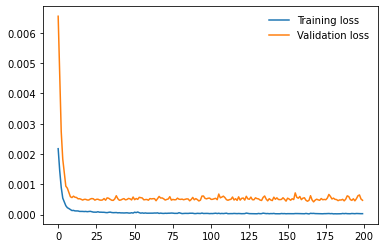

training accuracy = 99.70297029702971%
validation accuracy = 94.3620178041543%
test accuracy = 93.47181008902076%


In [388]:
from nn_utils import *

model = nn.Sequential(nn.Linear(feature_dim, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(512, 9),
                    nn.LogSoftmax(dim=1))

train_losses, validation_losses =\
    nn_train(model, X_train, Y_train, X_valid, Y_valid, epochs=2000, lr=0.01, validate_every=10, debug=False)

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()


model.load_state_dict(torch.load('model.pth'))
train_predictions = nn_predict(model, X_train)
validation_predictions = nn_predict(model, X_valid)
test_predictions = nn_predict(model, X_test)

print(f'training accuracy = {nn_accuracy(train_predictions, Y_train) * 100}%')
print(f'validation accuracy = {nn_accuracy(validation_predictions, Y_valid) * 100}%')
print(f'test accuracy = {nn_accuracy(test_predictions, Y_test) * 100}%')

In [156]:
# torch.save(model.state_dict(), 'model.pth')

train_predictions = nn_predict(model, X_train)
validation_predictions = nn_predict(model, X_valid)
test_predictions = nn_predict(model, X_test)

print(f'training accuracy = {nn_accuracy(train_predictions, Y_train) * 100}%')
print(f'validation accuracy = {nn_accuracy(validation_predictions, Y_valid) * 100}%')
print(f'test accuracy = {nn_accuracy(test_predictions, Y_test) * 100}%')

training accuracy = 100.0%
validation accuracy = 98.51632047477746%
test accuracy = 98.21958456973294%


In [50]:
from sklearn import svm, metrics

poly = svm.SVC(kernel = 'poly', C=1, degree=4, decision_function_shape='ovo').fit(X_train, Y_train)

train_predictions = poly.predict(X_train)
validation_predictions = poly.predict(X_valid)
test_predictions = poly.predict(X_test)

print(f'training accuracy = {metrics.accuracy_score(Y_train, train_predictions) * 100}%')
print(f'validation accuracy = {metrics.accuracy_score(Y_valid, validation_predictions) * 100}%')
print(f'test accuracy = {metrics.accuracy_score(Y_test, test_predictions) * 100}%')

training accuracy = 94.75247524752474%
validation accuracy = 93.76854599406528%
test accuracy = 92.87833827893175%
